# Use notebook to deploy Motus (via the wrapper read_counter.py) over a cluster with a Slurm resource manager and job scheduler.  
### Here, a job comprises a computer task performing taxonomic profiling of a MTG sample collected during the TARA Ocean expedition. 
### Based on this taxonomic profiling tool we can profile metagenomics (MTGs) datasets using a reference database of marker genes specific for a great variety of planktonic groups. This database was built using the following marker gene DBs:

The huge catalog of phytoplankton psbO marker gene sequences, which encodes the manganese-stabilising polypeptide of the photosystem II oxygen evolving complex, reported in this [paper](https://onlinelibrary.wiley.com/doi/epdf/10.1111/1755-0998.13592) and accessible [here](https://www.ebi.ac.uk/biostudies/studies/S-BSST761?query=A%20robust%20approach%20to%20estimate%20relative%20phytoplankton%20cell%20abundances%20from%20metagenomes).

The [MZGdb](https://metazoogene.org/MZGdb) database and most specifically the "All Plankton Combo" files contain all data from the All Zooplankton and the All Ichthyoplankton combined files. This database was described in this [paper](https://link.springer.com/article/10.1007/s00227-021-03887-y). Here we will focus on DNA sequences for the barcode region of mitochondrial cytochrome oxidase I (COI).  

</br>

Author: jay@newatlantis.io

Importing libraries

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
sns.set_style('ticks')
import glob 
from subprocess import Popen, call, STDOUT, PIPE
import os
import numpy as np
import matplotlib

In [2]:
matplotlib.rcParams['savefig.dpi'] = 1000
matplotlib.rcParams['figure.dpi'] = 900
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper")
sns.set(font='serif')
# sns.set_style("white", {
#         "font.family": "serif",
#         "font.serif": ["Times", "Palatino", "serif"]
#     })
sns.set_style('ticks')

Define some utility functions

In [3]:
def runShell(cmd):
    Popen(cmd,shell=True,stdout=PIPE,stderr=PIPE).communicate()[0]

### To submit jobs to the cluster using this notebook follow the steps below

Job script template to submit on a per-sample basis.  

**NOTE:** For properly setting the following script you must:  
   - Activate dedicated conda environment within which the motus software was installed (MOTUS_ENV)
   - Provide full path to all things Motus profiler (BASE_DIR), which contains data/ code/, etc. 
   - Provide full path to read_counter wrapper (READ_COUNTER_PATH), which  calls and runs Motus on a customized DB
   
**NOTE2:** The /readonly prefix in the bash script below can be removed for most clusters.

In [7]:
job_script_template = '''
#!/bin/bash
#PBS -l nodes=1:ppn=1
#PBS -l mem=30gb
#PBS -l walltime=24:00:00

#Activate conda environment
source activate ${MOTUS_ENV}

#Run script to fetch clean MTG/MTX paired-end reads from ftp server
bash /dodrio/scratch/projects/starting_2022_048/Motus/scripts/fetch_merge_pe_reads.sh %(accession_id)s %(ftp2r1)s %(ftp2r2)s

MERGED_READS=${BASE_DIR}/data/TARA_metaGs/%(accession_id)s_merged_reads.fastq
export INPUT_FASTQ=/readonly${MERGED_READS}

#NOTE: ${BASE_DIR}/data/custom_db/DB == ${BASE_DIR}/data/custom_db/CustomPhytoZooPlanktonMGs.fna
CUSTOM_DB=/readonly${BASE_DIR}/data/custom_db/DB

OUTPUT_MAPPING=${BASE_DIR}/results/%(accession_id)s_mapped_reads.map

cd ${BASE_DIR}/scripts

${READ_COUNTER_PATH}/read_counter map -s ${INPUT_FASTQ} -y insert.raw_counts -db ${CUSTOM_DB} -o ${OUTPUT_MAPPING} -l 80 -t 48

#Remove merged reads after running humann3
rm ${MERGED_READS}

'''

In [15]:
#Read in DF containing info on metaGs and metaTs
metag_df = pd.read_csv('../data/taxa_profiling_test_1/TARA_metaG_metadata.tsv',index_col='Unnamed: 0')

#ID samples by SAM accession ID
accessions_list = metag_df['sample_accession'].drop_duplicates().values

Loop over each SAM accession ID in list *accessions_list* and create a dedicated job script file to submit to the cluster.  

**WARNING:** Only run a couple of the whole list of accessions in *accessions_list*, otherwise you will get the whole system overloaded!!!  

To potentially prevent your system from collapsing, the code below is commented. Uncomment in case of running the whole set of samples contained in *accessions_list*.

In [10]:
# #Set type of sample, keep in mind that we are dealing with paired MTG-MTT
# for accid in accessions_list: 
    
#     #FTPs to fetch paired end reads from
#     ftp2r1, ftp2r2 = metag_df.query('sample_accession=="{}"'.format(accid))['submitted_ftp'].values[0].split(';')

#     #Create sample specific job script, save to dedicated folder and submit job
#     job_submit_script = job_script_template % {'accession_id':accid, 'ftp2r1':ftp2r1, 'ftp2r2':ftp2r2}
#     script_name = os.path.join('/dodrio/scratch/projects/starting_2022_048/Motus/scripts/','job_motus_sample_{}.sh'.format(accid))

#     #Dump text into .sh file
#     with open(script_name,'w') as fid:
#         fid.write(job_submit_script)

#     #Submit job
#     runShell("qsub {}".format(script_name))

</br>

### Next, after running the whole set of samples contained in *accessions_list*, check which output files (e.g. SAMEA*_mapped_reads.map) have been successfuly run to completion

In [11]:
get_all_output_files = glob.glob("../results/taxa_profiling_test_1/SAMEA*_mapped_reads.map")

success_runs = []
for ofn in get_all_output_files:
    with open(ofn,'r') as fid:
        l = fid.readlines()[1:]
        if(len(l)>10):
            success_runs.append(ofn.split('_')[0].split('/')[-1])
            
#Samples to re-run for metaGs            
sid_samples2rerun = list(set(accessions_list).difference(set(success_runs)))

# print("Total No. of jobs still pending for running: {}\n".format(len(sid_samples2rerun)))

print("No. success runs: {}".format(len(success_runs)))

No. success runs: 50


#### Analyzing taxonomic abundance profiles

In [14]:
#Cast all the counts for all samples in a DF
dfs_cont = []
for sid in success_runs:

    with open("../results/taxa_profiling_test_1/{}_mapped_reads.map".format(sid),'r') as fid:

        lines = fid.readlines()[1:]

        tax_cont = []
        count_cont = []
        for l in lines:
            tax, count = l.rstrip().split('\t')
            tax = tax.split('__')[-1]
            tax_cont.append(tax)
            count = float(count)
            count_cont.append(count)

        tax_counts_df = pd.DataFrame(data=count_cont,index=tax_cont,columns=[sid])
        dfs_cont.append(tax_counts_df)

#Fill NAN with 0
concat_dfs = pd.concat(dfs_cont).fillna(0)
#Get unique list of taxa identified
unique_idx_list = concat_dfs.index.drop_duplicates()
#Filtered by those that have a description down to at least species 
unique_idx_list = unique_idx_list[unique_idx_list.str.contains('_')]

In [25]:
#Do a bit of massaging here
concat_dfs = concat_dfs.loc[unique_idx_list].reset_index().groupby('index').sum()
#Filter rows
concat_dfs = concat_dfs.loc[concat_dfs.index.str.contains(';')]
#Sort columns by total counts
concat_dfs = concat_dfs[concat_dfs.sum().sort_values(ascending=False).index]

In [13]:
#Do some massaging here to get a properly formatted df
sorted_sid_dfs = []
for sid in concat_dfs.columns:
    sid_df = concat_dfs[sid].reset_index()
    sorted_sid_df = sid_df.sort_values(sid, ascending=False).drop_duplicates('index').set_index('index').loc[unique_idx_list]
    sorted_sid_dfs.append(sorted_sid_df)

In [39]:
# #Get a clean df with all the samples and unique idx/taxa
# cleaned_concat_dfs = pd.concat(sorted_sid_dfs, axis=1)
#Remove samples with relatively low summed counts
# cleaned_concat_dfs = cleaned_concat_dfs[cleaned_concat_dfs.columns[cleaned_concat_dfs.sum() > 50]]
cleaned_concat_dfs = concat_dfs[concat_dfs.columns[concat_dfs.sum()>50]]

In [40]:
#Now let's filter taxa by cutoff for max value observed across samples (>=10) & min number of observations (>=1) with min counts >= 3
unique_idx_list2 = cleaned_concat_dfs.index

filtered_taxa = []
for idx in unique_idx_list2:
    tax_profile = cleaned_concat_dfs.loc[idx]
    max_count = tax_profile.max()
    if(max_count>=5 & sum(tax_profile>=1)>=3):
        filtered_taxa.append(idx)
        
#Cast filtered data into a new df
new_cleaned_concat_df = cleaned_concat_dfs.loc[filtered_taxa]
new_cleaned_concat_df = new_cleaned_concat_df.loc[new_cleaned_concat_df.index[new_cleaned_concat_df.index.str.contains(';')]]
#Apply a simple log transformed with a pseudocount to prevent inf
# log_transf_cleaned_concat_df = (new_cleaned_concat_df + 1).applymap(np.log10)

In [41]:
#Running the python tool taxaranks: this is to extract the full lineage of each identified taxon

#First fetch highest taxonomic level
high_tax_lvls = new_cleaned_concat_df.index.map(lambda x: x.split(';')[-1]).map(lambda s: s.replace('_', ' ')).values
taxa_input = '../data/taxa_profiling_test_1/taxa.input'
taxa_output = '../data/taxa_profiling_test_1/taxa.output'
taxa_err = '../data/taxa_profiling_test_1/taxa.err'

# with open(taxa_input,'w') as fid:
#     for ele in high_tax_lvls:
#         fid.write(ele + '\n')
        
###Run taxaranks to fetch tax lineages (call the executable directly)
###NOTE: make sure to pass the full path to the executable: taxaranks!
# !${SCRATCH_DATA}/envs/biobakery3/bin/taxaranks -i $taxa_input -o $taxa_output

#Read in df with tax lineages
tax_lineages = pd.read_csv(taxa_output,sep='\t').fillna('undefined')
# tax_lineages['user_taxa'] = tax_lineages['user_taxa'].map(lambda s: s.replace(' ','_'))
tax_lineages.drop_duplicates('user_taxa', inplace=True)
tax_lineages.set_index('user_taxa',inplace=True)

print("Total number of distinct taxonomic groups: {}".format(tax_lineages.shape[0]))

Total number of distinct taxonomic groups: 61


In [42]:
#Set a new df for plotting purposes
new_cleaned_concat_df2 = new_cleaned_concat_df.copy()
new_cleaned_concat_df2.index = new_cleaned_concat_df2.index.map(lambda s: s.split(';')[-1].replace('_', ' '))
new_cleaned_concat_df2 = new_cleaned_concat_df2.loc[tax_lineages.index]
#Set index to family level
new_cleaned_concat_df2.index = new_cleaned_concat_df2.index.map(tax_lineages['family'].to_dict())
#Group data by user_taxa to shape the df in a way that we can generate the stacked barplots
aggr_cleaned_concat_df = new_cleaned_concat_df2.reset_index().groupby('user_taxa').sum()
#Filter again by counts
aggr_cleaned_concat_df2 = aggr_cleaned_concat_df[aggr_cleaned_concat_df.columns[(aggr_cleaned_concat_df.sum() >= 30)]]
#Rename index
aggr_cleaned_concat_df2.index.name = 'Family'
#Drop rows labbeld 'undefined' 
aggr_cleaned_concat_df2 = aggr_cleaned_concat_df2.loc[~aggr_cleaned_concat_df2.index.str.contains('undefined')]

#### The following plot is to illustrate taxonomic (family) abundance (raw) profiles  

To make this more interesting let's filter samples, and keep only those with eco-regions defined

In [43]:
#Fetch marine ecoregions from metadata loaded at the top of this NB
marine_ecoregions = metag_df.set_index('sample_accession')['marine region'].loc[aggr_cleaned_concat_df2.columns].dropna().sort_values()
marine_ecoregions = marine_ecoregions.apply(lambda s: s.split("Marine Ecoregion:")[-1])

In [44]:
#Filter columns and rename with more meaningful ones
aggr_cleaned_concat_df3 = aggr_cleaned_concat_df2[marine_ecoregions.index]
aggr_cleaned_concat_df3.columns = marine_ecoregions.values

### Lastly, visualize compositional taxonomic profiles across samples.  
**NOTE:** In notebook *CustomDB_MTG_Taxa_Profiling_v1.0.ipynb*, results obtained using the pipeline described above are shown using a sunburst plot!

In [46]:
#Each colum if given in percentages so that its total sums up to 1
aggr_cleaned_concat_df4 = (aggr_cleaned_concat_df3/aggr_cleaned_concat_df3.sum())

In [47]:
#Label columns with total number of counts per sample
#Get total counts quantified above
total_counts = aggr_cleaned_concat_df3.sum().values
new_col_labels = []
for (n,c) in enumerate(aggr_cleaned_concat_df4.columns):
    new_col_labels.append(c.split('(')[0] + '(N={})'.format(int(total_counts[n])))
    
aggr_cleaned_concat_df4.columns = new_col_labels

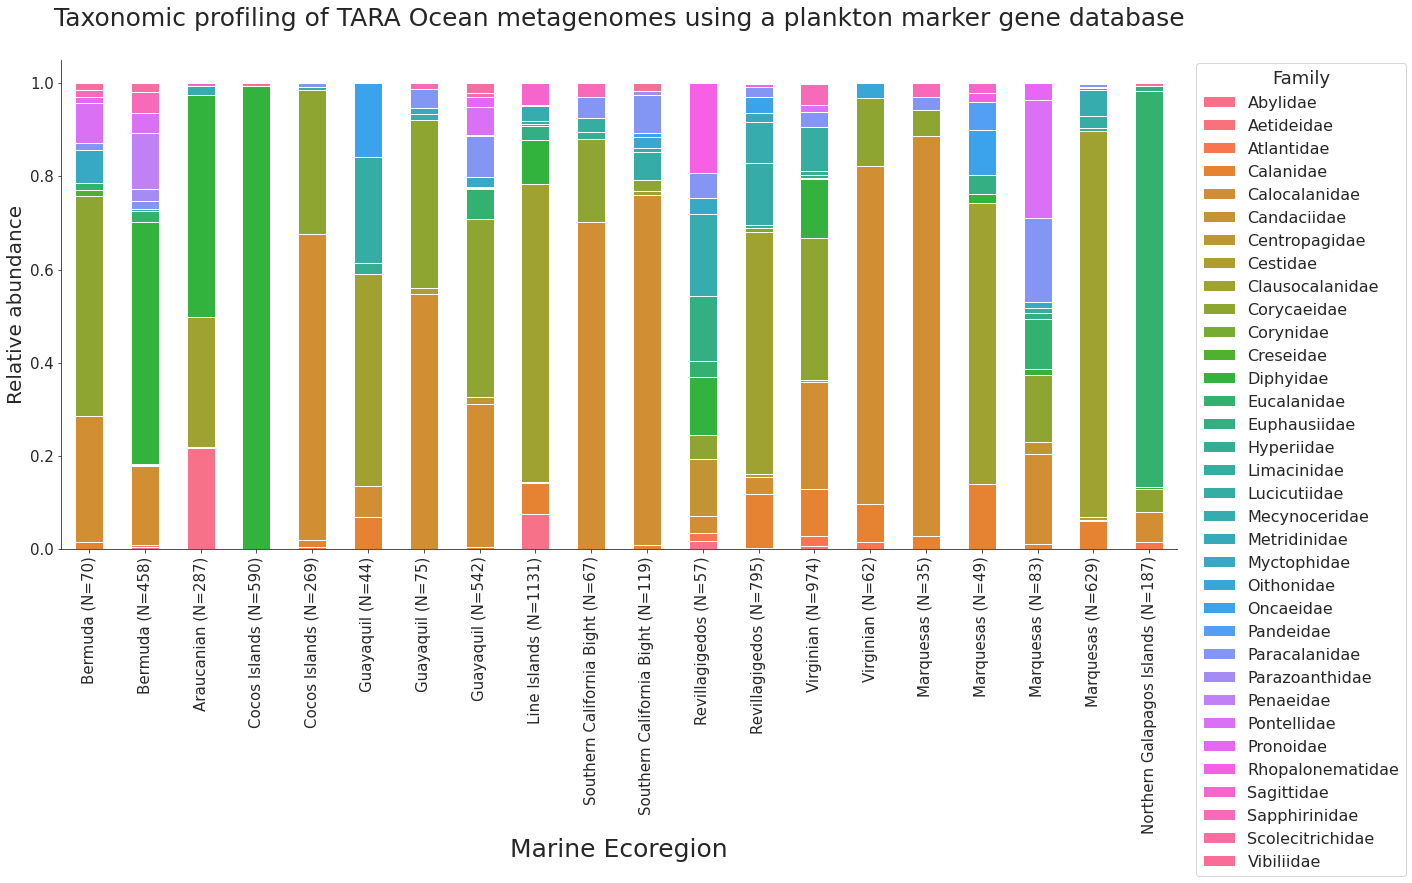

In [48]:
fig, ax = plt.subplots(figsize=(20,9))
# log_transf_cleaned_concat_df.T.plot(ax=ax, kind='bar', stacked=True, legend=False)
sbplots = aggr_cleaned_concat_df4.T.plot(ax=ax, kind='bar', stacked=True, legend=True, 
                             colormap= ListedColormap(sns.color_palette("husl", 60))
                             )
sns.despine()
ax.legend(title="Family", ncol =1, bbox_to_anchor=(1.01, 0.05, 0.025, 0.96), fontsize=16, title_fontsize=18)
#Alternative layout for legend labels: on top
# ax.legend(title="Family", ncol =6, bbox_to_anchor=(0.5, 1.07, 0.51, 0.4), fontsize=16, title_fontsize=18)

ax.set_title("Taxonomic profiling of TARA Ocean metagenomes using a plankton marker gene database\n", fontsize=25)
ax.set_xlabel("Marine Ecoregion", fontsize=25)
ax.set_ylabel("Relative abundance", fontsize=20)
ax.tick_params(axis='both', labelsize=15)
fig.show()